# НИРС ТМО Даниелян А.А.


Для исследования будем использовать набор данных о различной музыке - https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre/data


## Импорт библиотек и загрузка данных

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="ticks")
from warnings import simplefilter
from pandas.errors import SettingWithCopyWarning

simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
data = pd.read_csv('music_genre.csv')
#Удалим дубликаты, если присутствуют:
data = data.drop_duplicates()

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.


### Основные характеристики датасетов

In [ ]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,5
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,5
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,5
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,5
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,5


In [ ]:
data.shape

(50001, 18)

In [ ]:
data.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

In [ ]:
data.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

In [ ]:
data.isnull().sum()

instance_id         1
artist_name         1
track_name          1
popularity          1
acousticness        1
danceability        1
duration_ms         1
energy              1
instrumentalness    1
key                 1
liveness            1
loudness            1
mode                1
speechiness         1
tempo               1
obtained_date       1
valence             1
music_genre         1
dtype: int64

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

Очистим строки, которые содержат null

In [4]:
data = data.dropna()

Закодируем категориальный признак - жанр музыки.

In [5]:
genres = sorted(list(pd.unique(data["music_genre"])))


In [6]:
le = LabelEncoder()

for feature in ['music_genre']:
    data[feature] = le.fit_transform(data[feature])

    print(f"Уникальные значения для {feature}: {le.classes_}")

Уникальные значения для music_genre: ['Alternative' 'Anime' 'Blues' 'Classical' 'Country' 'Electronic'
 'Hip-Hop' 'Jazz' 'Rap' 'Rock']


Обработаем колонку с именем песни так, чтобы она несла информационную ценность

In [7]:
data.reset_index(inplace=True)
def ElementsofTrackName(element: str) -> pd.Series:
    print("number of songs in each group include {} in track_name".format(element))
    sub_df = pd.DataFrame({"{}".format(element): [], "music_genre": []})
    for i in range(len(data)):
        if element in data["track_name"][i]:
            sub_df.loc[len(sub_df.index)] = [
                data["track_name"][i],
                genres[data["music_genre"][i]],
            ]
    display(sub_df.groupby(["music_genre"])["music_genre"].count())

ElementsofTrackName(':')



number of songs in each group include : in track_name


music_genre
Alternative       8
Anime            75
Blues            14
Classical      3105
Country           6
Electronic       15
Hip-Hop          10
Jazz             18
Rap              11
Rock              5
Name: music_genre, dtype: int64

In [8]:
for element in [":", "Remix", "eat."]:
    data["{} in track name".format(element)] = [0] * len(data)

    # A new column named "{} in track name" is added to the DataFrame `df` with all values initialized to 0.

    for i in range(len(data)):
        if element in data["track_name"][i]:
            data["{} in track name".format(element)][i] = 1

Закодируем значение тональности

In [9]:
data["key"] = LabelEncoder().fit_transform(data["key"])

Закодируем значение лада

In [10]:
data['Major'] = data['mode'].apply(lambda x: 1 if x == 'Major' else 0)
data['Minor'] = data['mode'].apply(lambda x: 1 if x == 'Minor' else 0)

Заменим в столбце tempo значения ? на nan

In [11]:
data["tempo"] = data["tempo"].replace("?", np.nan).astype(np.float64)

Очистим столбцы, которые  не будем использовать для построения моделей, так как они не несут информационной ценности

In [12]:
data = data.drop(["instance_id", "artist_name", "track_name", "obtained_date", "mode", "index"], axis=1)

Заполним недостающие значения

In [13]:
names = data.columns
data = pd.DataFrame(KNNImputer().fit_transform(data), columns=names)

Масштабирование данных не требуется, так как все используемые данные уже отмасштабированы. Вспомогательные признаки строить не будем.

### Построение графиков для понимания структуры данных

In [ ]:
#sns.pairplot(data, hue="music_genre")

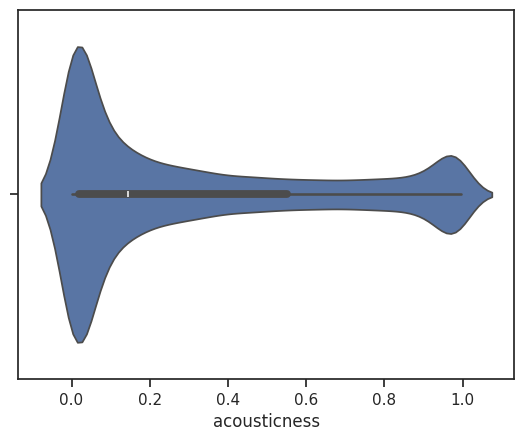

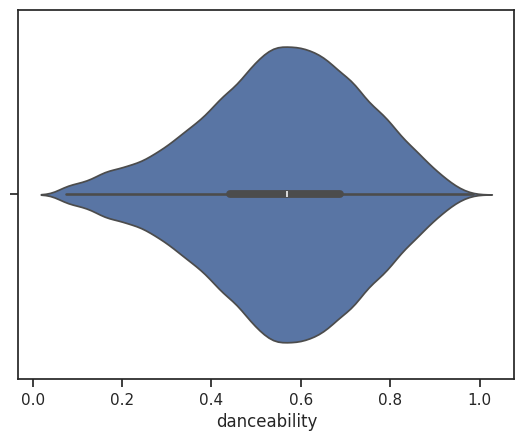

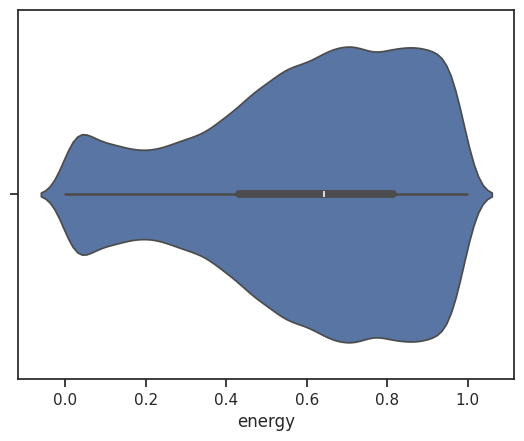

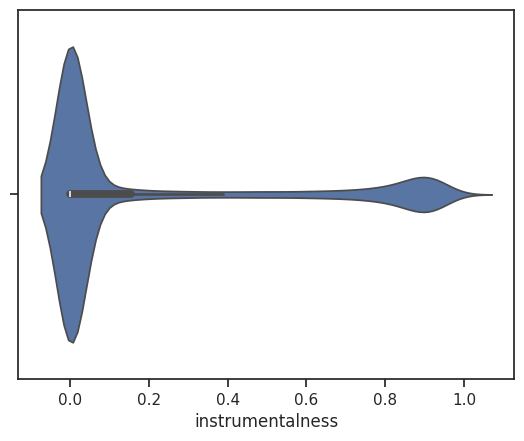

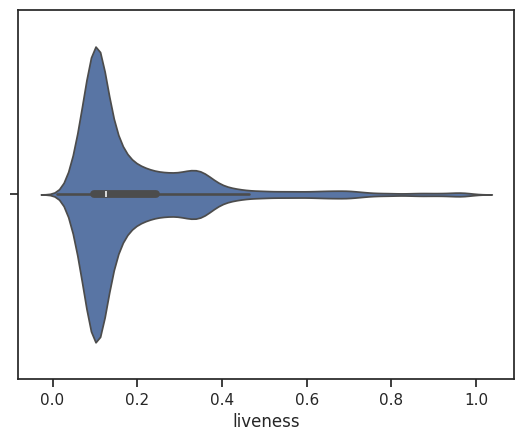

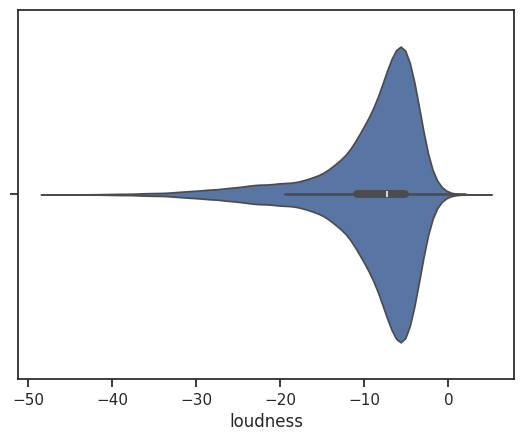

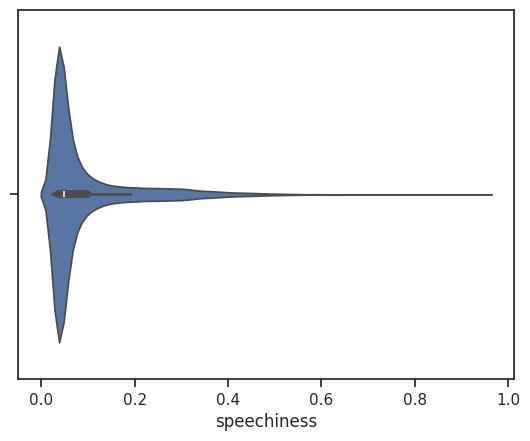

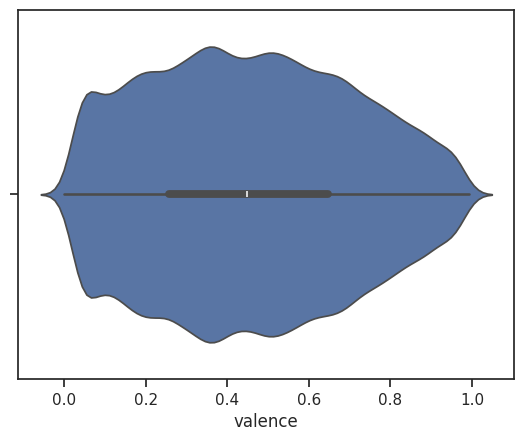

In [ ]:
# Скрипичные диаграммы для числовых колонок
for col in [
       'acousticness', 'danceability', 'energy',
       'instrumentalness',  'liveness', 'loudness',
       'speechiness', 'valence']:
    sns.violinplot(x=data[col])
    plt.show()

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

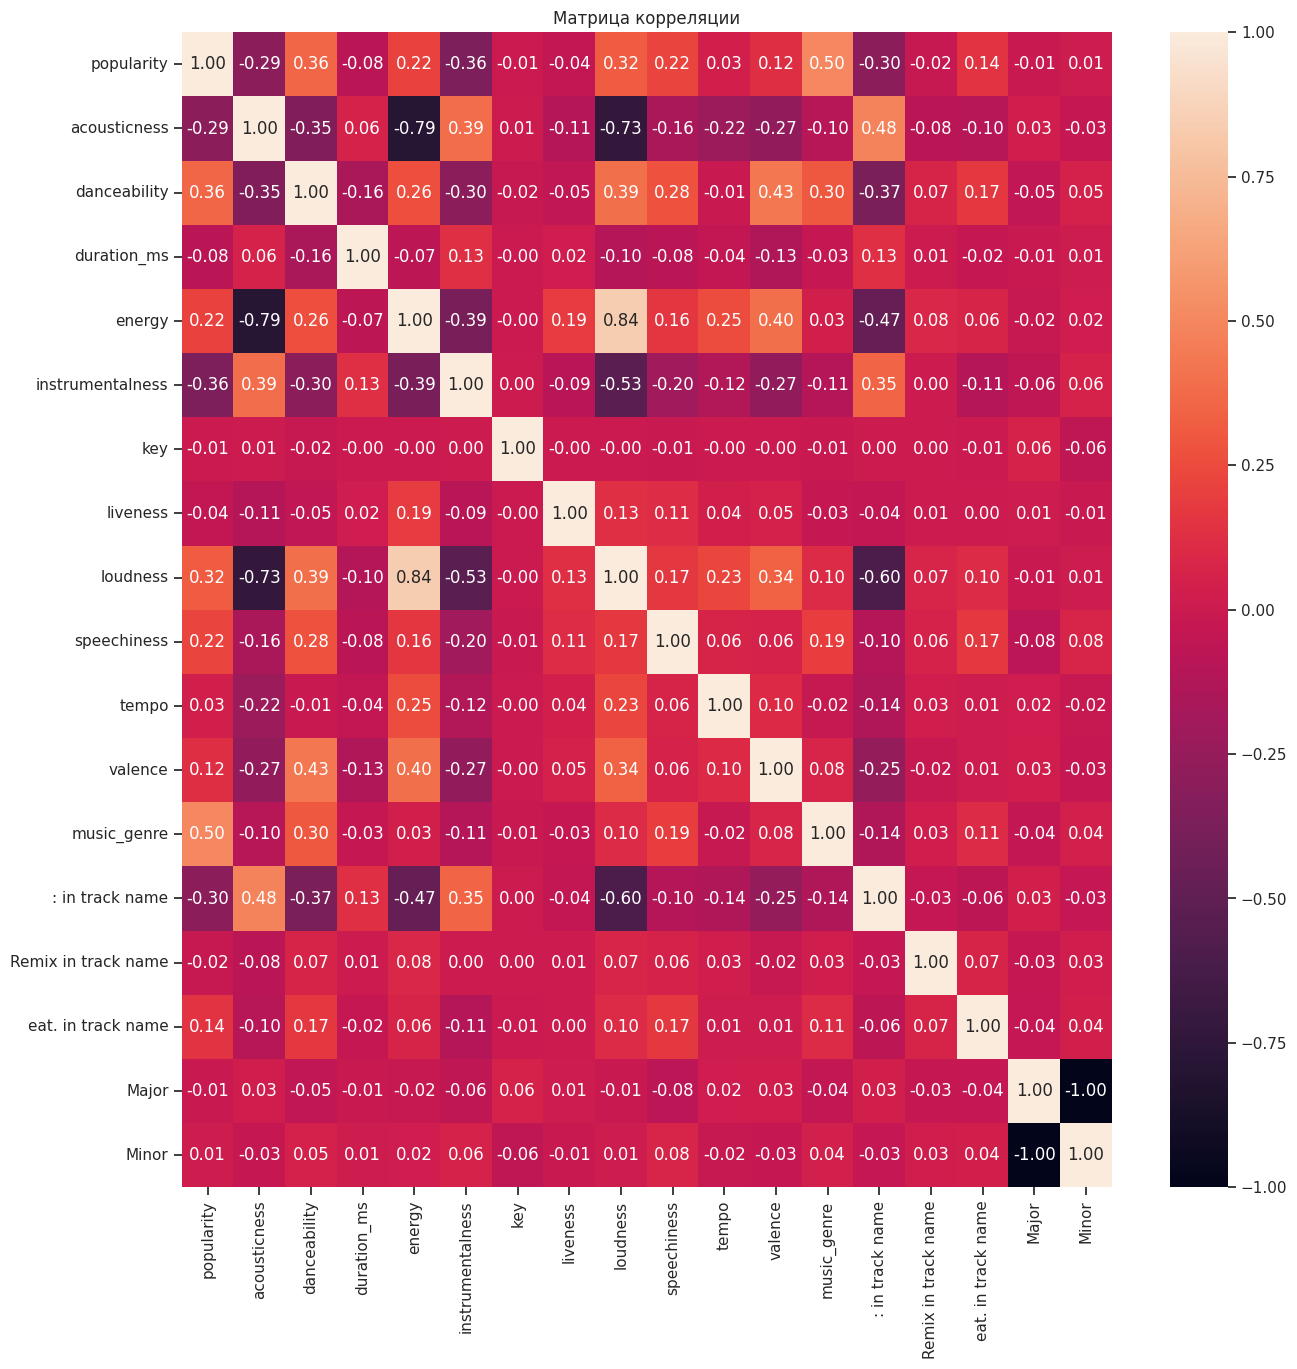

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
ax.set_title('Матрица корреляции')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:


*   Большая часть данных довольно слабо коррелирует между собой
*   Целевой признак 'music_genre' наиболее сильно коррелирует с 'dancebility'(0.30). Этот признак следует оставить в модели классификации.
*   Признаки 'energy' и 'loudness' имеют корреляцию близкую к 1, поэтому в модели можно использовать только признак 'loudness', так как он наиболее сильно коррелирует с целевым признаком.
 * По таблице видно, что признаки Major и Minor обратны друг другу, поэтому можно использовать лишь одиниз них
###### Несмотря на относительно слабую корреляцию признаков, модель все же можно построить.

In [14]:
data = data.drop(['energy', 'Minor'], axis=1)

## Выбор метрик для последующей оценки качества моделей.

### В качестве метрик будем использовать:
**Метрики, формируемые на основе матрицы ошибок:**

**Метрика precision:**
Можно переводить как точность, но такой перевод совпадает с переводом метрики "accuracy".

precision=TP/(TP+FP)
Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция precision_score.

**Метрика recall (полнота):**
recall=TP/(TP+FN)
Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция recall_score.

**Метрика F1-мера**
Для того, чтобы объединить precision и recall в единую метрику используется
Fβ-мера, которая вычисляется как среднее гармоническое от precision и recall:
Fβ=(1+β2)⋅precision⋅recallprecision+recall
где β определяет вес точности в метрике.
На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при β=1:

F1=2⋅precision⋅recallprecision+recall
Для вычисления используется функция f1_score.

 **Метрика ROC AUC**
Основана на вычислении следующих характеристик:

TPR=TP(TP+FN)
 - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

FPR=FP(FP+TN)
 - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция roc_auc_score.

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.


Для задачи классификации будем использовать следующие модели:

* Логистическая регрессия
* Метод ближайших соседей
* Машина опорных векторов
* Решающее дерево
* Случайный лес
* Градиентный бустинг

## Масштабирование

In [15]:
# Числовые колонки для масштабирования
scale_cols = [
       'acousticness', 'danceability',
       'instrumentalness',  'liveness', 'loudness',
       'speechiness',  'valence', 'popularity', 'tempo']

sc1 = MinMaxScaler()
scaled_data = sc1.fit_transform(data[scale_cols])

# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = scaled_data[:,i]

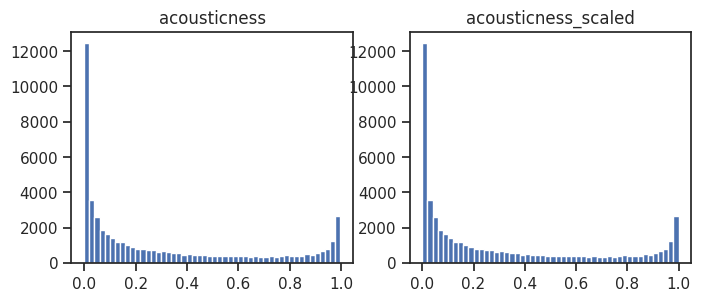

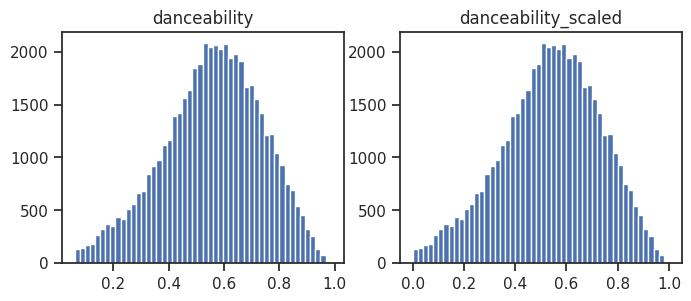

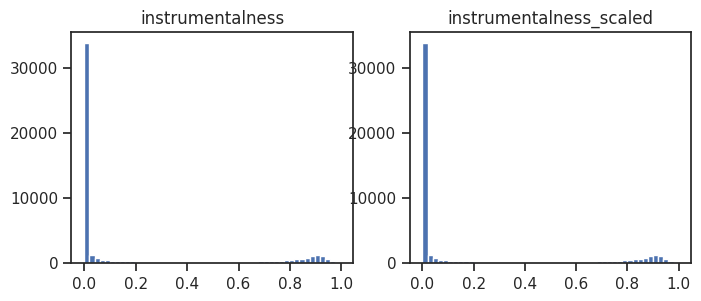

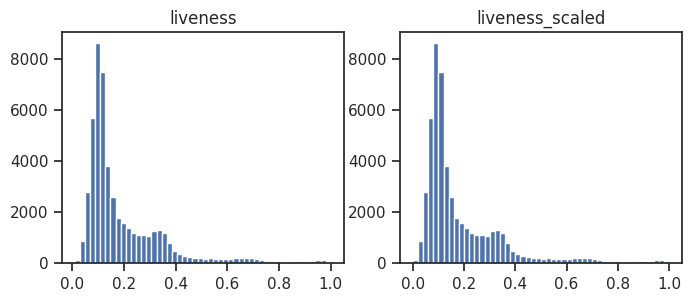

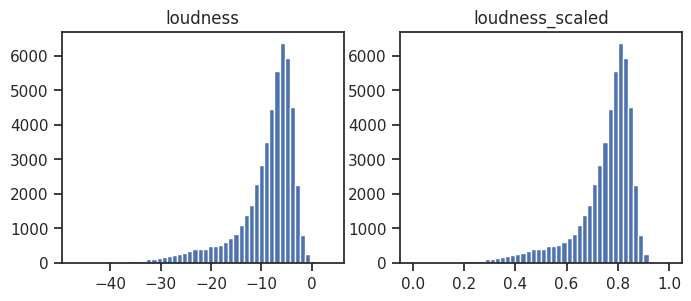

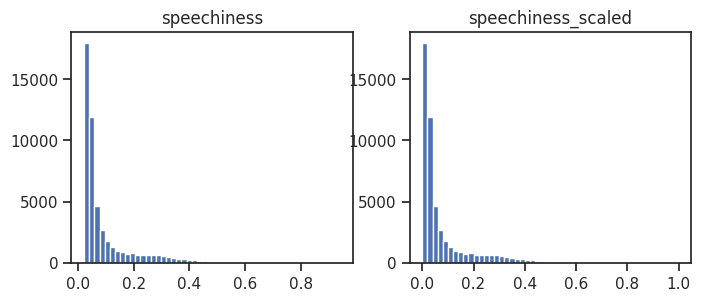

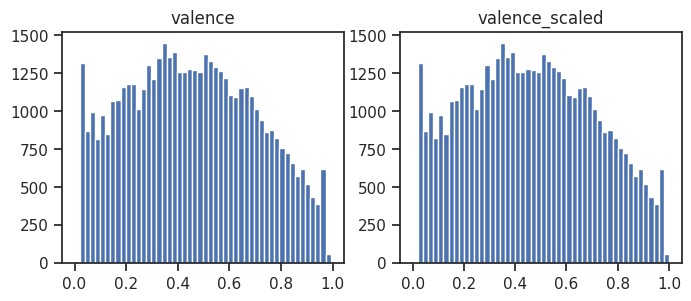

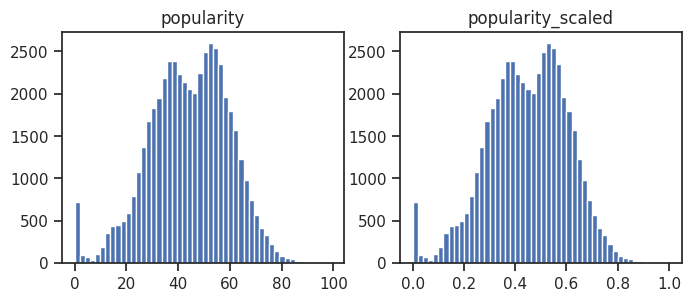

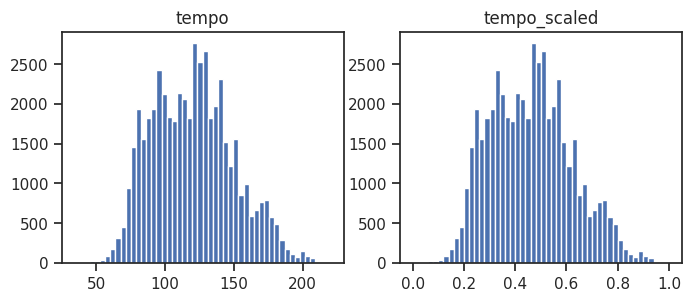

In [16]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## Формирование обучающей и тестовой выборок на основе исходного набора данных.


In [17]:
X = data.drop('music_genre', axis=1)
y = data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [18]:
# Модели
clas_models = {'LogR': LogisticRegression(max_iter=1000),
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}
# Сохранение метрик
clasMetricLogger = pd.DataFrame(columns=['ModelName', 'MetricName', 'Value'])

In [19]:
def plot_multiclass_roc(y_score,y_test, X_test, n_classes, figsize=(6, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], genres[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [20]:
from sklearn.metrics import  classification_report
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(X_train, y_train)
    # Предсказание значений
    Y_pred = model.predict(X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]

    precision = precision_score(y_test.values, Y_pred, average ='macro')
    recall = recall_score(y_test.values, Y_pred,average ='macro')
    f1 = f1_score(y_test.values, Y_pred, average ='macro')
    clasMetricLogger.loc[len(clasMetricLogger)] = [model_name, 'PR_SCORE', precision]
    clasMetricLogger.loc[len(clasMetricLogger)] = [model_name, 'RECALL', recall]
    clasMetricLogger.loc[len(clasMetricLogger)] = [model_name, 'F1',f1]

    # Plot roc_auc
    plot_multiclass_roc(Y_pred_proba, y_test, X_test, 8)


    # Visualize the confusion matrix
    cm = confusion_matrix(y_test.values, Y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix of {model_name}')
    plt.show()

    print(f'Classification report of {model_name}')
    print(classification_report(y_test.values, Y_pred))

Таблица соответствия классов:
0:Alternative
1:Anime
2:Blues
3:Classical
4:Country
5:Electronic
6:Hip-Hop
7:Jazz


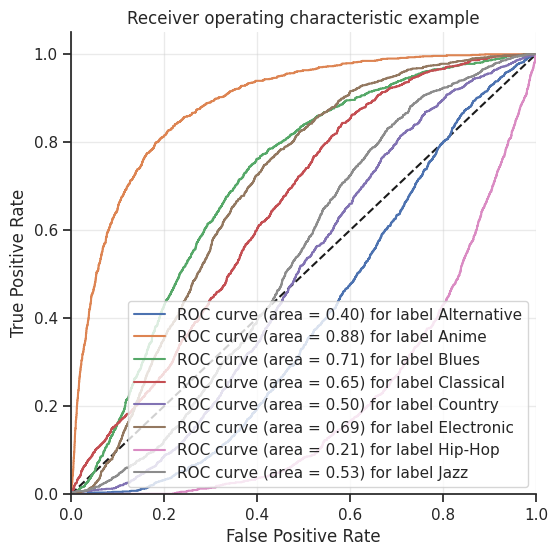

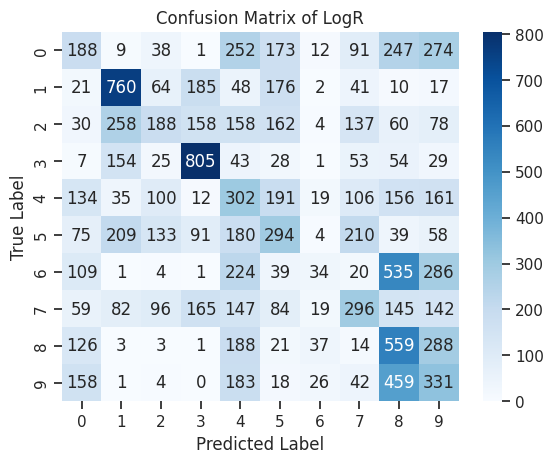

Classification report of LogR
              precision    recall  f1-score   support

         0.0       0.21      0.15      0.17      1285
         1.0       0.50      0.57      0.54      1324
         2.0       0.29      0.15      0.20      1233
         3.0       0.57      0.67      0.61      1199
         4.0       0.18      0.25      0.21      1216
         5.0       0.25      0.23      0.24      1293
         6.0       0.22      0.03      0.05      1253
         7.0       0.29      0.24      0.26      1235
         8.0       0.25      0.45      0.32      1240
         9.0       0.20      0.27      0.23      1222

    accuracy                           0.30     12500
   macro avg       0.29      0.30      0.28     12500
weighted avg       0.29      0.30      0.28     12500



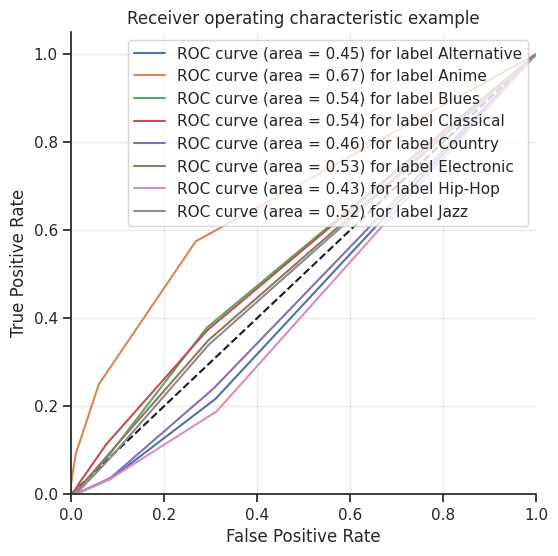

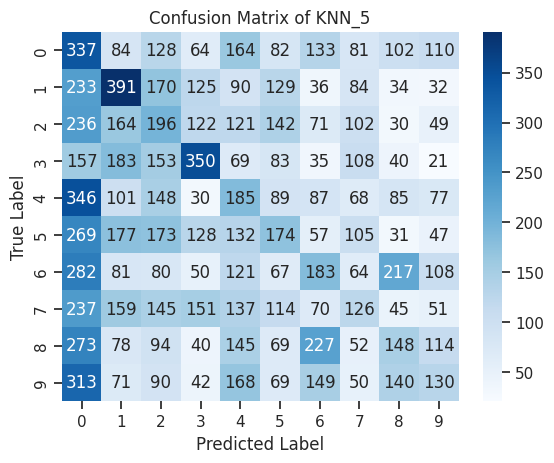

Classification report of KNN_5
              precision    recall  f1-score   support

         0.0       0.13      0.26      0.17      1285
         1.0       0.26      0.30      0.28      1324
         2.0       0.14      0.16      0.15      1233
         3.0       0.32      0.29      0.30      1199
         4.0       0.14      0.15      0.15      1216
         5.0       0.17      0.13      0.15      1293
         6.0       0.17      0.15      0.16      1253
         7.0       0.15      0.10      0.12      1235
         8.0       0.17      0.12      0.14      1240
         9.0       0.18      0.11      0.13      1222

    accuracy                           0.18     12500
   macro avg       0.18      0.18      0.18     12500
weighted avg       0.18      0.18      0.18     12500



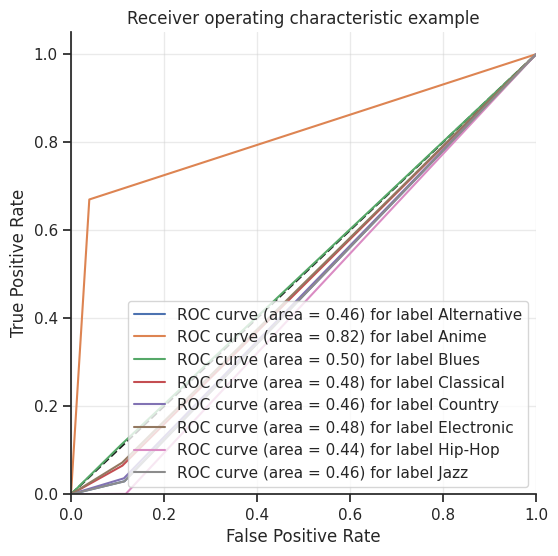

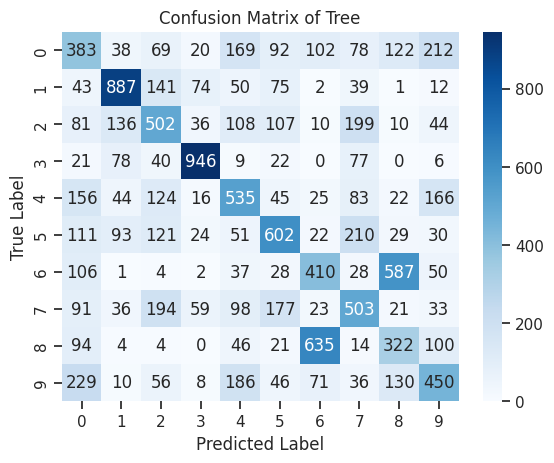

Classification report of Tree
              precision    recall  f1-score   support

         0.0       0.29      0.30      0.29      1285
         1.0       0.67      0.67      0.67      1324
         2.0       0.40      0.41      0.40      1233
         3.0       0.80      0.79      0.79      1199
         4.0       0.42      0.44      0.43      1216
         5.0       0.50      0.47      0.48      1293
         6.0       0.32      0.33      0.32      1253
         7.0       0.40      0.41      0.40      1235
         8.0       0.26      0.26      0.26      1240
         9.0       0.41      0.37      0.39      1222

    accuracy                           0.44     12500
   macro avg       0.44      0.44      0.44     12500
weighted avg       0.44      0.44      0.44     12500



In [ ]:
print ("Таблица соответствия классов:")
[print(f'{i}:{genres[i]}') for i in range(8)]
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Подбор гиперпараметров для выбранных моделей.

In [22]:
n_range_list = list(range(0,100,20))
n_range_list[0] = 5

In [23]:
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 20, 40, 60, 80])}]

In [24]:
print('all ok')
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=3, scoring='f1_macro')
print('all ok x2')
clf_gs.fit(X_train, y_train)

all ok
all ok x2


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 20, 40, 60, 80])}],
             scoring='f1_macro')

In [25]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=80)

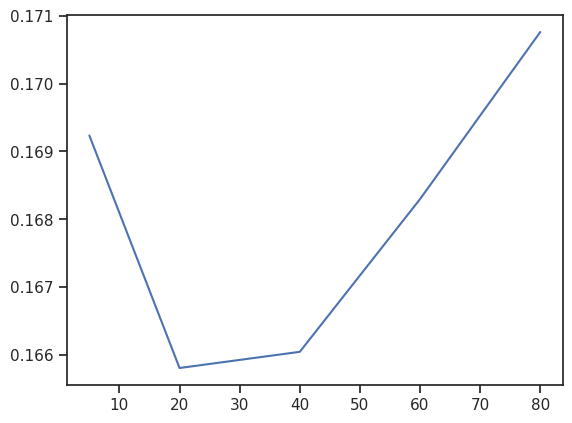

In [26]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

## Сравнение качества полученных моделей с качеством baseline-моделей.

In [28]:
clas_models_grid = {'KNN_5':KNeighborsClassifier(n_neighbors=5),
                    str('KNN_' + '60'):clf_gs.best_estimator_}


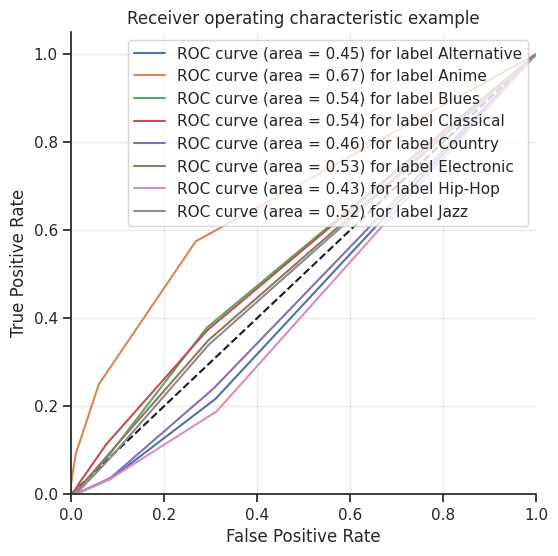

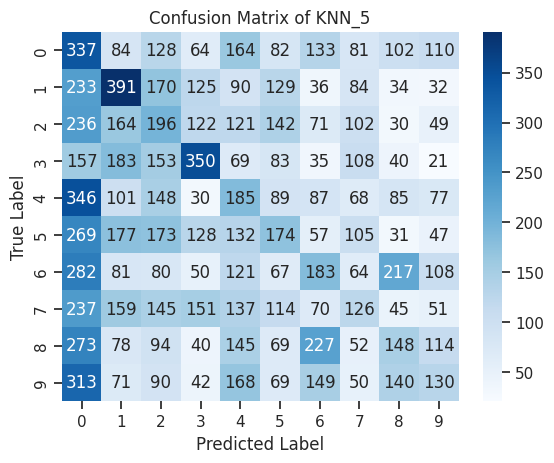

Classification report of KNN_5
              precision    recall  f1-score   support

         0.0       0.13      0.26      0.17      1285
         1.0       0.26      0.30      0.28      1324
         2.0       0.14      0.16      0.15      1233
         3.0       0.32      0.29      0.30      1199
         4.0       0.14      0.15      0.15      1216
         5.0       0.17      0.13      0.15      1293
         6.0       0.17      0.15      0.16      1253
         7.0       0.15      0.10      0.12      1235
         8.0       0.17      0.12      0.14      1240
         9.0       0.18      0.11      0.13      1222

    accuracy                           0.18     12500
   macro avg       0.18      0.18      0.18     12500
weighted avg       0.18      0.18      0.18     12500



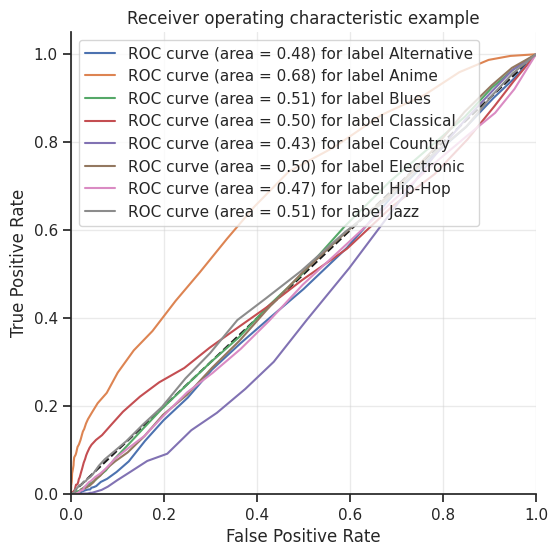

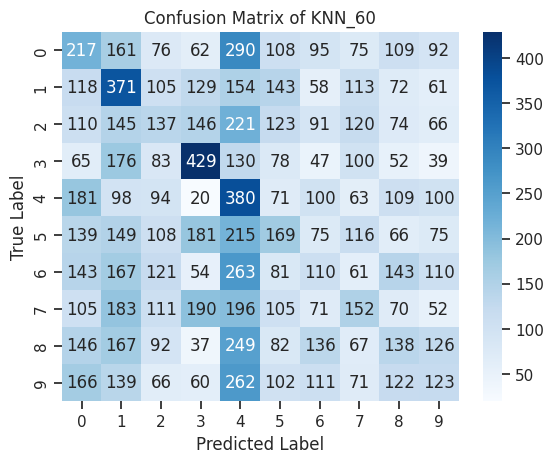

Classification report of KNN_60
              precision    recall  f1-score   support

         0.0       0.16      0.17      0.16      1285
         1.0       0.21      0.28      0.24      1324
         2.0       0.14      0.11      0.12      1233
         3.0       0.33      0.36      0.34      1199
         4.0       0.16      0.31      0.21      1216
         5.0       0.16      0.13      0.14      1293
         6.0       0.12      0.09      0.10      1253
         7.0       0.16      0.12      0.14      1235
         8.0       0.14      0.11      0.13      1240
         9.0       0.15      0.10      0.12      1222

    accuracy                           0.18     12500
   macro avg       0.17      0.18      0.17     12500
weighted avg       0.17      0.18      0.17     12500



In [29]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Формирование выводов о качестве построенных моделей на основе выбранных метрик.

In [31]:
# Метрики качества модели
#clasMetricLogger = pd.DataFrame(columns=['ModelName', 'MetricName', 'Value'])
clas_metrics = clasMetricLogger['MetricName'].unique()
clas_metrics

array(['PR_SCORE', 'RECALL', 'F1'], dtype=object)

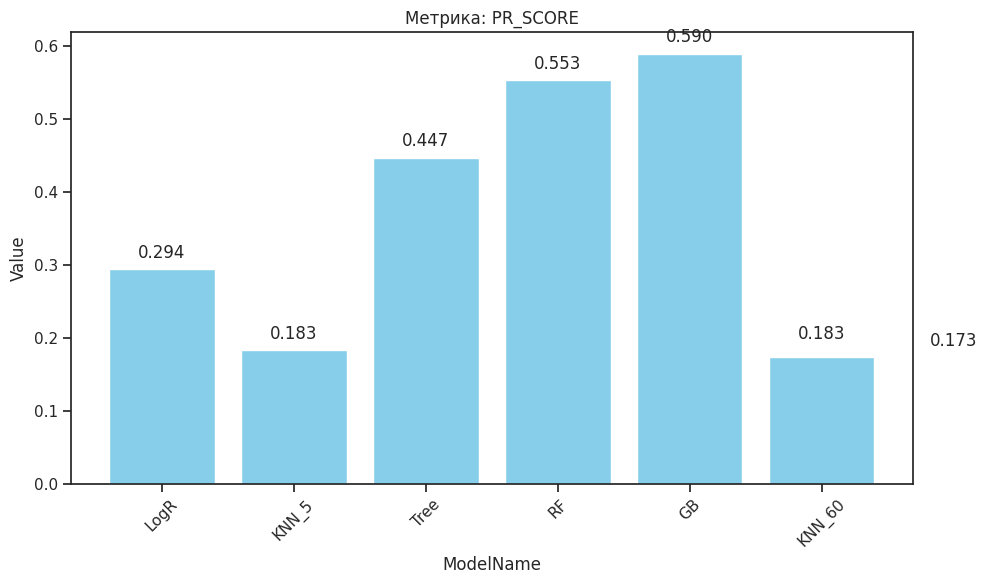

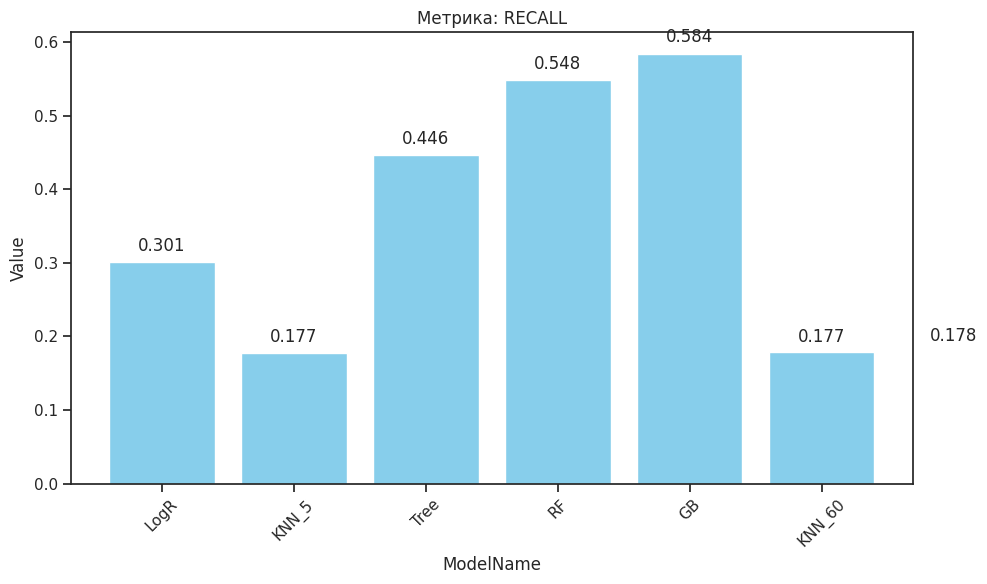

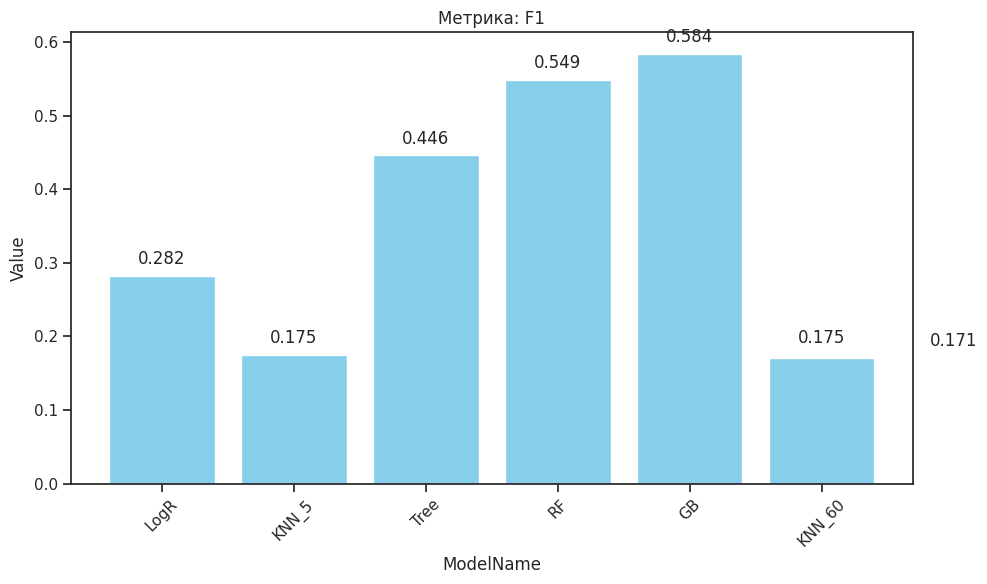

In [35]:
def plot_metric(clasMetricLogger, metric_name):
    # Фильтрация DataFrame для отображения только интересующей метрики
    filtered_df = clasMetricLogger[clasMetricLogger['MetricName'] == metric_name][['ModelName', 'Value']]

    # Создание столбчатой диаграммы
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_df['ModelName'], filtered_df['Value'], color='skyblue')

    # Добавление подписей к столбцам
    for i, value in enumerate(filtered_df['Value']):
        plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

    plt.xlabel('ModelName')
    plt.ylabel('Value')
    plt.title(f'Метрика: {metric_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Использования функции для каждой из метрик
metrics = ['PR_SCORE', 'RECALL', 'F1']
for metric in metrics:
    plot_metric(clasMetricLogger, metric)

**Вывод: на основании трех метрик оказалось, что наилучшие результаты классификации показала моодель градиентного бустинга. Также можно увиидеть, что подбор гиперпараметров для модели K ближайших соседей, согласно выбранным метрикам, не улучшил качество классификации.**

